In [7]:
!which python3

/home/essanhaji/projects/moroccan-lpr-ocr/venv/bin/python3


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping
from keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split
from livelossplot.inputs.tf_keras import PlotLossesCallback
from keras.models import model_from_json
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import glob
import cv2
import os
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 1.5.0


``sudo apt-get install unrar``

In [10]:
from pyunpack import Archive

local_zip = 'dataset.rar'
Archive(local_zip).extractall('dataset')

In [11]:
link = "dataset/**/**/*.*"
dataset_paths = glob.glob(link)

for image_path in dataset_paths:

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_inv = cv2.bitwise_not(img)

    os. remove(image_path)

    cv2.imwrite("{}{}".format(image_path[:-4], ".png"), img)
    cv2.imwrite("{}_inverte{}".format(image_path[:-4], ".png"), img_inv)

### Visualize dataset

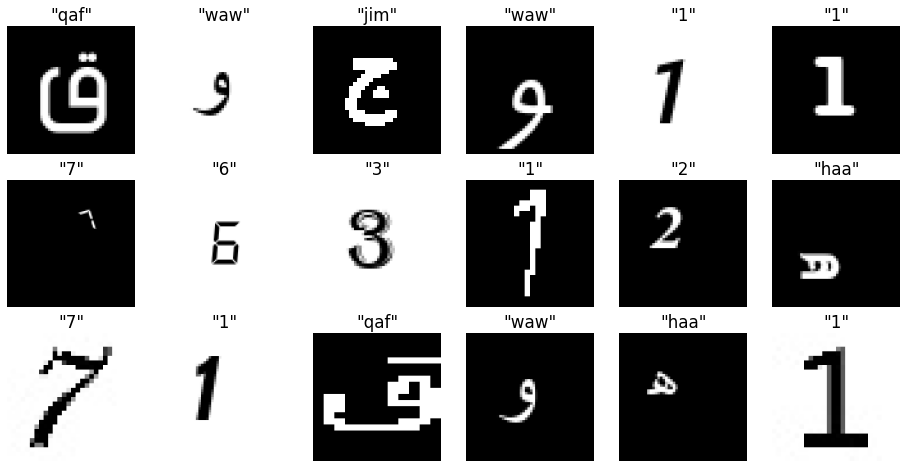

In [12]:
dataset_paths = glob.glob(link)

cols=6
rows=3

fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig)

np.random.seed(10)
rand = np.random.randint(0, len(dataset_paths), size=(cols*rows))

for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

## Data pre-processing

In [13]:
img_size = 128
batch_size = 128

dir_train = "dataset/train/"
dir_test  = "dataset/test/"

datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode="nearest",
                                   brightness_range= [0.7, 1.5])

train_generator = datagen_train.flow_from_directory(dir_train,
                                                    target_size=(img_size, img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


datagen_validation = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode="nearest",
                                   brightness_range= [0.7, 1.5])

validation_generator = datagen_validation.flow_from_directory(dir_test,
                                                    target_size=(img_size, img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 106130 images belonging to 19 classes.
Found 96964 images belonging to 19 classes.


## Initialize MobileNets architecture with pre-trained weight

In [14]:
def create_model(lr=1e-4, decay=1e-4/25, training=False, output_shape=19):

    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        for layer in baseModel.layers:
            layer.trainable = True

        optimizer = Adam(lr=lr, decay=decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    
        
    return model

In [16]:
init_lr = 1e-4
epochs = 2

model = create_model(lr=init_lr, decay=init_lr/epochs, training=True)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## Train model

In [ ]:
%%time

check_path = "checkpoint/mode_1.h5"

checkpoint = ModelCheckpoint(check_path, monitor='val_accuracy', mode='max', verbose=1)
earlystoping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

my_checkpointer = [PlotLossesKeras(), checkpoint, earlystoping]

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

result = model.fit_generator(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_generator,
                             validation_steps=validation_steps,
                             epochs=epochs,
                             callbacks=my_checkpointer)

## Precision and recall

In [ ]:
from sklearn.metrics import classification_report


predictions = model.predict_generator(validation_generator)
val_preds = np.argmax(predictions, axis=1)

val_trues = validation_generator.classes

In [ ]:
labels = validation_generator.class_indices.keys()
print(classification_report(list(val_trues), list(val_preds)))

In [ ]:
labels = validation_generator.class_indices.keys()
labels

In [ ]:
model.save("checkpoint/model/1.h5")

In [ ]:
model = tf.keras.models.load_model("checkpoint/model/1.h5")

In [ ]:
from keras.preprocessing import image

img = image.load_img("/content/drive/MyDrive/data/real_world_images/2/13.png", target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predictions = model.predict(images)
classe = np.argmax(predictions, axis=1)
labels = validation_generator.class_indices.keys()
print(predictions[0])
print(predictions[0][int(classe[0])])
print(list(labels)[int(classe[0])])

# chars[int(list(labels)[int(classe)])]

## The End!